# Analysis

# 1. Import libraries

In [1]:
# Required libraries
import numpy as np
import pandas as pd
from datetime import datetime

#visualization library
import matplotlib.pyplot as plt
import seaborn as sns

import dis_func as func

#import libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

from sklearn import tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDClassifier
cv = KFold(n_splits=10)
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, auc
import sklearn.metrics as metrics
import xgboost as xgb

# 2. Import data

In [2]:
data='keyword.csv'
dfo=pd.read_csv(data,sep=',',skiprows=2)
df=dfo.copy()
print ('Uploaded data has', len(df),'rows and',len(df.columns),'columns!')

Uploaded data has 1265993 rows and 56 columns!


#  3. Data pre-processing

In [3]:
#remove column percentages and convert to float
def replace_comma(row):
    if ',' in row:
        return row.replace(',','')
    else:
        return row
    
def percent2float(row):
    if row.endswith('%'):
        return float(row[:-1])/100
    else:
        pass

def change_q_scorerow(row):
    if row == ' --':
        return 0
    else:
        return float(row)
    
def change_dash_row(row):
    if row == ' --':
        return 0
    else:
        return row

#round up conversions
#round conversions to 1 if 0<conversions<1, and round down if any other integer
def round_conv(row):
    if row >0 and row <1:
        return 1
    else:
        return int(row)
    
# count number of strings and integers in a column
def count_str_int(column_name):
    string=0
    inte=0
    floaty=0
    unk=0
    for i in df[column_name]:
        if type(i) == str:
            string+=1
        elif type(i) == int:
            inte+=1
        elif type(i) == float:
            floaty+=1
        else:
            unk +=1
    print('====================================')
    print(column_name)
    print("There are a total of ",string,"strings,",inte,"integers,",floaty,"floats",unk,"number of other formats")
    print("There are a total of ",string+inte,"rows in this column")
    print('====================================')
    
#find number of words
def get_number_of_words(row):
    return len(row.split())

In [4]:
# retain top 80% of keywords
cumsum=df.groupby('Search keyword').sum()[['Conversions','Clicks']].sort_values(by='Conversions',ascending=False)
cumsum['cum_perc'] = 100*cumsum['Conversions'].cumsum()/cumsum['Conversions'].sum()
#top 80% of keywords
#filter out top 118 keywords
df=df[df['Search keyword'].isin(list((cumsum[cumsum['cum_perc']<80.1])['cum_perc'].index))]

In [5]:
# drop rows with zero CPC
df=df[df['Avg. CPC']>0]

In [6]:
#get number of words column
df['No. of words']=df['Search keyword'].apply(func.get_number_of_words)

#round up conversions values
df['Conversions']=df['Conversions'].apply(func.round_conv)

In [7]:
## drop ad columns that are useless
ad_cols_to_drop=['Headline','Short headline', 'Long headline', 'Responsive Search Ad headline 1','Responsive Search Ad headline 2', 'Responsive Search Ad headline 3','Responsive Search Ad headline 4', 'Responsive Search Ad headline 5','Responsive Search Ad headline 6', 'Responsive Search Ad headline 7', 'Responsive Search Ad headline 8', 'Responsive Search Ad headline 9', 'Responsive Search Ad headline 10', 'Responsive Search Ad headline 11', 'Responsive Search Ad headline 12', 'Responsive Search Ad headline 13','Responsive Search Ad headline 14', 'Responsive Search Ad headline 15','Responsive Search Ad description 1', 'Responsive Search Ad description 2','Responsive Search Ad description 3','Responsive Search Ad description 4', 'Expanded text ad description 2', 'Description line 1','Description line 2','Ad']
df=df.drop(df[ad_cols_to_drop],axis=1)

In [8]:
def fill_nan():
#     columns_fillna=['Headline','Description line 1','Description line 2','Display URL','Ad']
    columns_fillna=['Display URL']
    for i in columns_fillna:
        df[i]=df[i].fillna('Insuro.co.uk')
fill_nan()

In [9]:
# combine headline variables:
# text_ads_columns=['Headline','Headline 1','Headline 2','Description line 1','Description line 2','Expanded text ad headline 3','Responsive Search Ad headline 1','Responsive Search Ad headline 2','Responsive Search Ad headline 3','Responsive Search Ad headline 4','Responsive Search Ad headline 5','Responsive Search Ad headline 6','Responsive Search Ad description 1','Responsive Search Ad description 2','Responsive Search Ad description 3','Responsive Search Ad description 4','Description','Expanded text ad description 2','Ad']  
text_ads_columns=['Headline 1','Headline 2','Expanded text ad headline 3','Description']  
landing_page=['Path 1','Path 2']
df['text_ads']=''
df['landing_page']=''
for i in text_ads_columns:
    df['text_ads']=df['text_ads']+df[i]
for i in landing_page:
    df['landing_page']+=df[i]

In [10]:
#drop ads and url related columns, along with those with just one variable
single_var=[]
for i in df.columns:
    if df[i].nunique()==1:
        single_var.append(i)

drop_col_list=text_ads_columns+landing_page+single_var
df.drop(drop_col_list,axis=1,inplace=True)

In [11]:
# convert all text groups and landing page to Ad Group # and Landing Page #
# 37 landing page groups
# 226 text ad groups
text_ad_group=[]
landing_page_group=[]
for i in list(range(1,df['text_ads'].nunique()+1)):
    i='Ad Group '+str(i)
    text_ad_group.append(i)

for i in list(range(1,df['landing_page'].nunique()+1)):
    i='Landing Page Group '+str(i)
    landing_page_group.append(i)    
    
text_ad_group=pd.concat([pd.DataFrame(df['text_ads'].value_counts().sort_values(ascending=False)).reset_index(),pd.DataFrame(text_ad_group)], axis=1).drop(['text_ads'],axis=1).set_index('index').reset_index()
text_ad_group.columns=['ad group','Text Ad Group']
landing_page_group=pd.concat([pd.DataFrame(df['landing_page'].value_counts().sort_values(ascending=False)).reset_index(),pd.DataFrame(landing_page_group)], axis=1).drop(['landing_page'],axis=1).set_index('index').reset_index()
landing_page_group.columns=['landing page','Landing Page']

df=pd.merge(df,text_ad_group,left_on='text_ads',right_on='ad group').drop(['text_ads','ad group'],axis=1)
df=pd.merge(df,landing_page_group,left_on='landing_page',right_on='landing page').drop(['landing_page','landing page'],axis=1)

In [12]:
#Standardize CPC on each keyword
#Create Standardized Column
avgcpc_stddev=pd.DataFrame(df[df['Conversions']>0].groupby('Search keyword').agg(np.std, ddof=0)['Avg. CPC']).rename(index=str, columns={"Avg. CPC": "Avg. CPC_StdDev"})
avgcpc_mean=pd.DataFrame(df[df['Conversions']>0].groupby('Search keyword').agg(np.mean)['Avg. CPC']).rename(index=str,columns={'Avg. CPC':'Avg. CPC_Mean'})
df=pd.merge(df, avgcpc_stddev.join(avgcpc_mean), right_index=True, left_on='Search keyword')
df['Avg. CPC_zscore']=(df['Avg. CPC']-df['Avg. CPC_Mean'])/df['Avg. CPC_StdDev']

In [13]:
# create dummies (RUN ONCE!)
# get_dummies_list=['Search keyword match type','Day of week','Device','Network (with search partners)','Landing page experience','Expected click-through rate','Ad relevance','Ad Group','Landing Page','Display URL']
get_dummies_list=['Search keyword match type','Day of week','Device','Network (with search partners)','Landing page experience','Expected click-through rate','Ad relevance','Landing Page','Display URL']

df=pd.get_dummies(df, columns=get_dummies_list,drop_first=True)

In [14]:
#create binary
def conv_binary(row):
    if row['Conversions'] ==0:
        val = 0
    elif row['Conversions'] > 0:
        val = 1
    else:
        val=0
    return val

df['Converted']=df.apply(conv_binary,axis=1)

In [15]:
#Run resampling technique

from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_resam,y_resam=sm.fit_resample(X,y_conv_bin)
X_train_resam, X_test_resam, y_train_resam, y_test_resam = train_test_split(X_resam, y_resam, test_size=0.2, random_state=42)

clf_conv = LogisticRegression()
clf_conv.fit(X_train_resam,y_train_resam)
y_pred_resam=clf_conv.predict(X_test_resam)
print(accuracy_score(y_test_resam,y_pred_resam))
print(confusion_matrix(y_test_resam, y_pred_resam))

fpr, tpr, threshold = metrics.roc_curve(y_test_resam, y_pred_resam)
roc_auc = metrics.auc(fpr, tpr)
print(roc_auc)

ModuleNotFoundError: No module named 'imblearn'

# 4. Model construction

In [16]:
columns_to_drop=['Search keyword','Campaign','Campaign','Day','Clicks', 'Avg. CPC_StdDev','Avg. CPC_Mean','Ad group',
                 'Text Ad Group',
                 'Keyword max CPC','Avg. CPC','Impressions', 'CTR', 'Cost','Avg. position', 'Conversions', 
                 'Cost / conv.','Conv. rate','Converted']

In [17]:
X=df.drop(columns_to_drop,axis=1)
y=(df['Conversions'])

X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## OLS Summary

In [18]:
#summary of OLS
from statsmodels.api import OLS
OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Conversions   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.233
Method:                 Least Squares   F-statistic:                     486.6
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:23:18   Log-Likelihood:            -2.5414e+05
No. Observations:               83337   AIC:                         5.084e+05
Df Residuals:                   83285   BIC:                         5.089e+05
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
No. of words                                       0.3190      0.012     25.889      0.000       0.295       0.343
Avg. CPC_zscore                                    0.5073      0.018     28.249      0.000       0.472       0.542
Search keyword match type_Exact                   -0.4565      0.044    -10.413      0.000      -0.542      -0.371
Search keyword match type_Phrase                  -0.0184      0.056     -0.328      0.743      -0.129       0.092
Day of week_Monday                                 0.7220      0.061     11.915      0.000       0.603       0.841
Day of week_Saturday                               0.6054      0.061      9.922      0.000       0.486       0.725
Day of week_Sunday                                 0.4988      0.061      8.162      0.000       0.379       0.619
Day of week_Thursday                               0.7183      0.061     11.772      0.000       0.599       0.838
Day of week_Tuesday                                0.7163      0.061     11.831      0.000       0.598       0.835
Day of week_Wednesday                              0.7256      0.061     11.886      0.000       0.606       0.845
Device_Mobile                                      2.6213      0.041     63.276      0.000       2.540       2.702
Device_Tablet                                      0.0527      0.060      0.883      0.377      -0.064       0.170
Network (with search partners)_Search partners    -1.1820      0.118    -10.050      0.000      -1.413      -0.951
Landing page experience_Average                    0.8604      0.112      7.691      0.000       0.641       1.080
Landing page experience_Below average             -0.1859      0.819     -0.227      0.820      -1.791       1.419
Expected click-through rate_Average                0.0488      0.053      0.924      0.356      -0.055       0.152
Expected click-through rate_Below average         -0.1678      0.183     -0.918      0.359      -0.526       0.191
Ad relevance_Average                               0.4160      0.097      4.300      0.000       0.226       0.606
Ad relevance_Below average                        -1.2632      0.040    -31.423      0.000      -1.342      -1.184
Landing Page_Landing Page Group 10                -1.8473      0.364     -5.070      0.000      -2.561      -1.133
Landing Page_Landing Page Group 11                -0.3747      0.645     -0.581      0.561      -1.640       0.890
Landing Page_Landing Page Group 12                -0.4347      0.723     -0.601      0.548      -1.852       0.983
Landing Page_Landing Page Group 13                -1.6083      0.771     -2.086      0.037      -3.120      -0.097
Landing Page_Landing Page Group 14                -1.9839      0.808     -2.455      0.014   

## Base model

In [19]:
# Base models
    
#Random forest
# rf_base = RandomForestRegressor(n_estimators=200,max_depth=4,max_features='sqrt',random_state=42)
# rf_base.fit(X,y)
# print(mean_squared_error(rf.predict(X_val),y_val))

#OLS with kfold
# baseline model
lm_base = linear_model.LinearRegression()
fold_mse_conv_lm_base = []
fold_max_conv_lm_base=[]
fold_min_conv_lm_base=[]
fold_r2_base=[]
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index], 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    lm_base.fit(X_train, y_train)
    y_pred_base=lm_base.predict(X_test)
    fold_mse_conv_lm_base.append(mean_squared_error(y_pred_base,y_test))
#     fold_max_conv_lm.append(y_pred.max())
#     fold_min_conv_lm.append(y_pred.min())
print(np.mean(fold_mse_conv_lm_base))

rf_base =RandomForestRegressor(n_estimators=200,max_depth=4,max_features='sqrt',random_state=42)
fold_mse_conv_rf_base = []
fold_max_conv_rf_base=[]
fold_min_conv_rf_base=[]
fold_r2=[]
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index], 
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf_base.fit(X_train, y_train)
    y_pred_rf_base=rf_base.predict(X_test)
    fold_mse_conv_rf_base.append(mean_squared_error(y_pred_rf_base,y_test))
#     fold_max_conv_rf_base.append(y_pred.max())
#     fold_min_conv_lm.append(y_pred.min())

print(np.mean(fold_mse_conv_rf_base))

25.87651772484952
26.25758569996043


In [20]:
#Dataset for classification of 0 or more than 0
y_conv_bin=pd.DataFrame(y).apply(conv_binary,axis=1)

#dataset for regressor
#get dataset with more than 0
X_train_regr=X[X.index.isin(y[y>0].index)]
y_train_regr=y[y>0]

## Part 1 model construction (Classification)

In [199]:
#L1 Log Reg
clf_conv_lr1 = LogisticRegression(penalty='l1')
logregl1_misclass = []
logregl1_confmat=0
logregl1_rocauc=[]
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index], 
    y_train, y_test = y_conv_bin.iloc[train_index], y_conv_bin.iloc[test_index]
    clf_conv_lr1.fit(X_train, y_train)
    y_conv_pred=clf_conv_lr1.predict(X_test)
    logregl1_misclass.append(accuracy_score(y_test, y_conv_pred))
    logregl1_confmat=logregl1_confmat+confusion_matrix(y_test, y_conv_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_conv_pred)
    roc_auc = metrics.auc(fpr, tpr)
    logregl1_rocauc.append(roc_auc)
print(logregl1_misclass)
print(logregl1_confmat)
print(logregl1_rocauc)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

[0.7023380093520374, 0.7045697487974345, 0.6998931052912881, 0.6992250133618386, 0.7008284339925174, 0.6874665954035275, 0.6968198824158204, 0.7111170497060395, 0.7014965259219669, 0.6942811330839124]
[[ 1695 21252]
 [ 1215 50679]]
[0.5224030430601807, 0.5288659511671994, 0.5277934902910895, 0.5293094828537961, 0.518949599270659, 0.5223643144563636, 0.5254018156229456, 0.5271618700757108, 0.5278848372376338, 0.5222260435421837]


In [200]:
#L2 Log Reg
clf_conv_lr2 = LogisticRegression(penalty='l2')
logregl2_misclass = []
logregl2_confmat=0
logregl2_rocauc=[]
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index], 
    y_train, y_test = y_conv_bin.iloc[train_index], y_conv_bin.iloc[test_index]
    clf_conv_lr2.fit(X_train, y_train)
    y_conv_pred=clf_conv_lr2.predict(X_test)
    logregl2_misclass.append(accuracy_score(y_test, y_conv_pred))
    logregl2_confmat=logregl2_confmat+confusion_matrix(y_test, y_conv_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_conv_pred)
    roc_auc = metrics.auc(fpr, tpr)
    logregl2_rocauc.append(roc_auc)
print(logregl2_misclass)
print(logregl2_confmat)
print(logregl2_rocauc)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will 

[0.7022044088176352, 0.7045697487974345, 0.700026723677178, 0.6993586317477285, 0.7008284339925174, 0.6871993586317477, 0.6966862640299305, 0.7112506680919295, 0.7016301443078568, 0.6942811330839124]
[[ 1700 21247]
 [ 1220 50674]]
[0.5223074955730795, 0.5288659511671994, 0.5282498854513843, 0.5295249072398366, 0.5190769958226177, 0.5220566124076615, 0.5253051225268327, 0.5273874000712002, 0.527981343703567, 0.5222260435421837]


In [201]:
#### SGD Classifier
clf_conv_sgd = linear_model.SGDClassifier()
sgdclass_misclass = []
sgdclass_confmat=0
sgdclass_rocauc=[]
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index], 
    y_train, y_test = y_conv_bin.iloc[train_index], y_conv_bin.iloc[test_index]
    clf_conv_sgd.fit(X_train, y_train)
    y_conv_pred=clf_conv_sgd.predict(X_test)
    sgdclass_misclass.append(accuracy_score(y_test, y_conv_pred))
    sgdclass_confmat=sgdclass_confmat+confusion_matrix(y_test, y_conv_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_conv_pred)
    roc_auc = metrics.auc(fpr, tpr)
    sgdclass_rocauc.append(roc_auc)
print(sgdclass_misclass)
print(sgdclass_confmat)
print(sgdclass_rocauc)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

[0.6952571810287241, 0.6969535008017104, 0.6941475146980225, 0.6961517904863709, 0.6830571886691609, 0.6783805451630144, 0.6962854088722609, 0.71058257616248, 0.6997594869053981, 0.6917423837520043]
[[ 1999 20948]
 [ 1936 49958]]
[0.5275836939982261, 0.5130858285982365, 0.515004257651743, 0.5229317443917685, 0.5420571906764093, 0.5274127824627923, 0.5198775588659459, 0.5262597500937531, 0.5411024516497577, 0.5149836064263874]


In [93]:
clf_conv_sgd = linear_model.SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)
sgdclass_misclass = []
sgdclass_confmat=0
sgdclass_rocauc=[]
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index], 
    y_train, y_test = y_conv_bin.iloc[train_index], y_conv_bin.iloc[test_index]
    clf_conv_sgd.fit(X_train, y_train)
    y_conv_pred=clf_conv_sgd.predict(X_test)
    sgdclass_misclass.append(accuracy_score(y_test, y_conv_pred))
    sgdclass_confmat=sgdclass_confmat+confusion_matrix(y_test, y_conv_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_conv_pred)
    roc_auc = metrics.auc(fpr, tpr)
    sgdclass_rocauc.append(roc_auc)
print(sgdclass_misclass)
print(sgdclass_confmat)
print(sgdclass_rocauc)


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

[0.7150168518287355, 0.7198851579078767, 0.7047809262264386, 0.7146423667457247, 0.7133940831356884, 0.709274747222569, 0.7203844713518911, 0.7064036949194857, 0.7107726875546124, 0.718137560853826]
[[  123 22940]
 [   30 57017]]
[0.5033077949065063, 0.5016537875833279, 0.5024525430728601, 0.5023519578113493, 0.5022537198469715, 0.5018374243163984, 0.5031552233932388, 0.5020292511422714, 0.5022289040427536, 0.5027763432823795]


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [22]:
#Random forest classifier conversions

rf_conv = RandomForestClassifier(n_estimators=200, max_depth=4,random_state=0)
rf_misclass = []
rf_confmat=0
rf_rocauc=[]
for train_index, test_index in cv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index], 
    y_train, y_test = y_conv_bin.iloc[train_index], y_conv_bin.iloc[test_index]
    rf_conv.fit(X_train, y_train)
    y_conv_pred=rf_conv.predict(X_test)
    rf_misclass.append(accuracy_score(y_test, y_conv_pred))
    rf_confmat=rf_confmat+confusion_matrix(y_test, y_conv_pred)
    fpr, tpr, threshold = metrics.roc_curve(y_test, y_conv_pred)
    roc_auc = metrics.auc(fpr, tpr)
    rf_rocauc.append(roc_auc)
print(rf_misclass)
print(rf_confmat)
print(rf_rocauc)

[0.7211423086153108, 0.7297816174706023, 0.7215022798176146, 0.7236621070314375, 0.7335013198944085, 0.7243820494360451, 0.7212622990160787, 0.7245889835593424, 0.7321492859714389, 0.7238689547581904]
[[   30 22869]
 [    0 60438]]
[0.5, 0.5004436557231589, 0.5, 0.5, 0.5002250225022502, 0.5015190972222222, 0.5012881064834693, 0.5010869565217391, 0.5004476275738585, 0.5015164644714039]


In [43]:
misclass={'logregl1':np.mean(logregl1_misclass),'logregl2':np.mean(logregl2_misclass), 'sgd':np.mean(sgdclass_misclass),'rf':np.mean(rf_misclass)}
false_negative_rate={'logregl1':(logregl1_confmat[1][0]/np.sum(logregl1_confmat[1])),'logregl2':(logregl2_confmat[1][0]/np.sum(logregl2_confmat[1])), 'sgd':(sgdclass_confmat[1][0]/np.sum(sgdclass_confmat[1])),'rf':(rf_confmat[1][0]/np.sum(rf_confmat[1]))}
classification_results=pd.DataFrame([misclass, false_negative_rate],index=['Classification Acc','False Negative Rate']).T
classification_results

,Classification Acc,False Negative Rate
logregl1,0.730024,0.019855
logregl2,0.729964,0.019921
rf,0.725788,0.000066
sgd,0.728056,0.022238


# Part 2 (Continuous prediction)


### OLS summary

In [23]:
from statsmodels.api import OLS
OLS(y_train_regr,X_train_regr).fit().summary()

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Conversions   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     543.0
Date:                Mon, 29 Jul 2019   Prob (F-statistic):               0.00
Time:                        13:34:18   Log-Likelihood:            -1.9119e+05
No. Observations:               60438   AIC:                         3.825e+05
Df Residuals:                   60390   BIC:                         3.829e+05
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
No. of words                                       0.4102      0.016     25.387      0.000       0.379       0.442
Avg. CPC_zscore                                    0.5755      0.025     23.267      0.000       0.527       0.624
Search keyword match type_Exact                   -0.7223      0.057    -12.572      0.000      -0.835      -0.610
Search keyword match type_Phrase                  -0.1829      0.073     -2.497      0.013      -0.327      -0.039
Day of week_Monday                                 1.0158      0.080     12.730      0.000       0.859       1.172
Day of week_Saturday                               0.8171      0.080     10.183      0.000       0.660       0.974
Day of week_Sunday                                 0.7114      0.080      8.851      0.000       0.554       0.869
Day of week_Thursday                               0.9565      0.080     11.960      0.000       0.800       1.113
Day of week_Tuesday                                0.9759      0.080     12.247      0.000       0.820       1.132
Day of week_Wednesday                              0.9500      0.080     11.860      0.000       0.793       1.107
Device_Mobile                                      3.3252      0.055     61.009      0.000       3.218       3.432
Device_Tablet                                      0.1856      0.083      2.235      0.025       0.023       0.348
Network (with search partners)_Search partners    -0.8939      0.201     -4.444      0.000      -1.288      -0.500
Landing page experience_Average                    1.1087      0.154      7.200      0.000       0.807       1.411
Landing page experience_Below average              3.6146      1.811      1.995      0.046       0.064       7.165
Expected click-through rate_Average                0.0978      0.071      1.368      0.171      -0.042       0.238
Expected click-through rate_Below average         -0.1215      0.251     -0.485      0.628      -0.613       0.370
Ad relevance_Average                               0.6264      0.132      4.754      0.000       0.368       0.885
Ad relevance_Below average                        -1.4898      0.054    -27.815      0.000      -1.595      -1.385
Landing Page_Landing Page Group 10                -2.2500      0.654     -3.439      0.001      -3.532      -0.968
Landing Page_Landing Page Group 11                -0.2091      0.984     -0.213      0.832      -2.138       1.719
Landing Page_Landing Page Group 12                -0.2476      1.064     -0.233      0.816      -2.333       1.838
Landing Page_Landing Page Group 13                -2.1657      1.013     -2.137      0.033      -4.152      -0.180
Landing Page_Landing Page Group 14                -2.1508      1.389     -1.548      0.122   

### Test transformation

In [205]:
#split for transformation test

y_train_regr_tran=np.cbrt(y_train_regr)

#ols for transformation
lm_tran = linear_model.LinearRegression()
lm_mse_tran = []
lm_r2=[]
for train_index, test_index in cv.split(X_train_regr):
    X_train, X_test = X_train_regr.iloc[train_index], X_train_regr.iloc[test_index], 
    y_train, y_test =y_train_regr_tran.iloc[train_index], y_train_regr_tran.iloc[test_index]
    lm_tran.fit(X_train, y_train)
    y_pred=lm.predict(X_test)
    lm_mse_tran.append(mean_squared_error(y_pred**3,y_test**3)**0.5)

print(np.mean(lm_mse_tran))

0.8749750884785552


In [ ]:
# Transformation of y dependent variable
y_train_regr=np.cbrt(y_train_regr)

In [25]:
#OLS without penalizer

lm = linear_model.LinearRegression()
lm_mse = []
# fold_max_conv_lm=[]
# fold_min_conv_lm=[]
lm_r2=[]
for train_index, test_index in cv.split(X_train_regr):
    X_train, X_test = X_train_regr.iloc[train_index], X_train_regr.iloc[test_index], 
    y_train, y_test =y_train_regr.iloc[train_index], y_train_regr.iloc[test_index]
    lm.fit(X_train, y_train)
    y_pred=lm.predict(X_test)
    lm_mse.append(mean_squared_error(y_pred**3,y_test**3))
    lm_r2.append(r2_score(y_true=y_test**3, y_pred=y_pred**3))
print(np.mean(lm_mse))
print(lm_r2)

33.904449387898964
[0.039999073678476216, 0.04214725941642472, 0.04128563911703742, 0.052489009854309265, 0.04296756503603072, 0.04919252069247293, 0.043004378949440314, 0.03619449552255927, 0.03120130882520744, 0.049168325944984326]


In [26]:
lasso = linear_model.Lasso(alpha=0.1)
lasso_mse = []
# fold_max_conv_lm=[]
# fold_min_conv_lm=[]
lasso_r2=[]
for train_index, test_index in cv.split(X_train_regr):
    X_train, X_test = X_train_regr.iloc[train_index], X_train_regr.iloc[test_index], 
    y_train, y_test =y_train_regr.iloc[train_index], y_train_regr.iloc[test_index]
    lasso.fit(X_train, y_train)
    y_pred=lasso.predict(X_test)
    lasso_mse.append(mean_squared_error(y_pred**3,y_test**3))
    lasso_r2.append(r2_score(y_true=y_test**3, y_pred=y_pred**3))
print(np.mean(lasso_mse))
print(lasso_r2)

36.583994699672445
[-0.02993454083044278, -0.028372468931280093, -0.03836193897364604, -0.03572102181388015, -0.0388996297931723, -0.03267864348461269, -0.0319089853393677, -0.03521688870175432, -0.03174360230994755, -0.034205066358256486]


In [27]:
ridge = linear_model.Ridge(alpha=1)
ridge_mse = []
# fold_max_conv_lm=[]
# fold_min_conv_lm=[]
ridge_r2=[]
for train_index, test_index in cv.split(X_train_regr):
    X_train, X_test = X_train_regr.iloc[train_index], X_train_regr.iloc[test_index], 
    y_train, y_test =y_train_regr.iloc[train_index], y_train_regr.iloc[test_index]
    ridge.fit(X_train, y_train)
    y_pred=ridge.predict(X_test)
    ridge_mse.append(mean_squared_error(y_pred**3,y_test**3))
    ridge_r2.append(r2_score(y_true=y_test**3, y_pred=y_pred**3))
print(np.mean(ridge_mse))
print(ridge_r2)

33.906240278732355
[0.039953009059374045, 0.042149079755508856, 0.04123505249989401, 0.052430658228635685, 0.04288768660550135, 0.04913045199767463, 0.04295768330205707, 0.03614599713038458, 0.031135754722783626, 0.04911161015907939]


In [28]:
#SGD
from sklearn.linear_model import SGDRegressor
sgdr=SGDRegressor(loss="squared_loss", penalty="l2", max_iter=100)

sgdr_mse = []
# fold_max_conv_lm=[]
# fold_min_conv_lm=[]
sgdr_r2=[]
for train_index, test_index in cv.split(X_train_regr):
    X_train, X_test = X_train_regr.iloc[train_index], X_train_regr.iloc[test_index], 
    y_train, y_test =y_train_regr.iloc[train_index], y_train_regr.iloc[test_index]
    sgdr.fit(X_train, y_train)
    y_pred=sgdr.predict(X_test)
    sgdr_mse.append(mean_squared_error(y_pred**3,y_test**3))
    sgdr_r2.append(r2_score(y_true=y_test**3, y_pred=y_pred**3))
print(np.mean(sgdr_mse))
print(sgdr_r2)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDRegressor in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parame

33.94188598096671
[0.039869485192376763, 0.035575645179986015, 0.04939986700881338, 0.04693592377269584, 0.050529480735243326, 0.04522304103918029, 0.041089419401204585, 0.032863438091356945, 0.0323946051977676, 0.042397977570109435]


In [29]:
import xgboost as xgb
xgb = xgb.XGBRegressor(objective='reg:squarederror')
xgb_mse=[]
xgb_test=[]
xgb_pred=[]
for train_index, test_index in cv.split(X_train_regr):
    X_train, X_test = X_train_regr.iloc[train_index], X_train_regr.iloc[test_index], 
    y_train, y_test =y_train_regr.iloc[train_index], y_train_regr.iloc[test_index]
    xgb.fit(X_train, y_train)
    y_pred=xgb.predict(X_test)
    xgb_test.append(y_test)
    xgb_pred.append(y_pred)
    xgb_mse.append(mean_squared_error(y_pred**3,y_test**3))
print(np.mean(xgb_mse))

/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not N

32.28747049996934


In [40]:
regr_mse={'lm':np.mean(lm_mse),'logregl1':np.mean(lasso_mse),'logregl2':np.mean(ridge_mse), 'sgd':np.mean(sgdr_mse),'xgb':np.mean(xgb_mse)}
regr_results=pd.DataFrame([regr_mse],index=['Mean Squared Error']).T
regr_results.index=['LM','LM L1-Norm','LM L2-Norm','SGD','XGB']
regr_results

Text(0.5, 1.0, 'Mean Squared Error of models used')

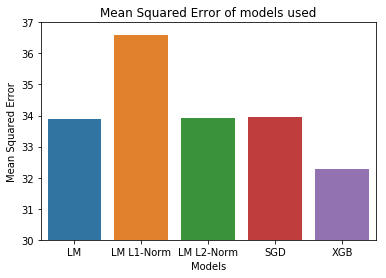

In [46]:
sns.barplot(x=regr_results.index,y='Mean Squared Error', data=regr_results)
plt.ylim([30,37])
plt.xlabel('Models')
plt.title('Mean Squared Error of models used')

## Grid Search

In [109]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

# Choose the type of classifier. 
clf_conv_sgd = linear_model.SGDClassifier()

# Choose some parameter combinations to try
parameters_class = {'loss' :['hinge','log'],
                    'alpha' :[0.0001,0.001,0.01,0.1]}


# Type of scoring used to compare parameter combinations
acc_scorer_class = make_scorer(accuracy_score)

# Run the grid search
grid_class = GridSearchCV(clf_conv_sgd, parameters_class, scoring=acc_scorer_class)
grid_class= grid_class.fit(X, y)

# Set the clf to the best combination of parameters
clf = grid_class.best_estimator_

# Fit the best algorithm to the data. 
# bclf.fit(X, y)

import xgboost as xgb
xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Choose some parameter combinations to try
parameters_regr = { 'max_depth' : [3,4,5],
                    'gamma' : ['0','0.5', '1', '2'],
                    'min_child_weight':['1','2', '3', '5']}
             
            
# Type of scoring used to compare parameter combinations
acc_scorer_regr = make_scorer(mean_squared_error)

# Run the grid search
grid_regr = GridSearchCV(xgb, parameters_regr, scoring=acc_scorer_regr)
grid_regr = grid_regr.fit(X_train_regr, y_train_regr)

# Set the clf to the best combination of parameters
regr = grid_regr.best_estimator_

# Fit the best algorithm to the data. 
# bclf.fit(X, y)
print(regr)
print(clf)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. Fr

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are l

/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not N

/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


KeyboardInterrupt: 

In [76]:
import xgboost as xgb
xgb = xgb.XGBRegressor(objective='reg:squarederror')

# Choose some parameter combinations to try
parameters_regr = { 'max_depth' : [3,4,5],
                    'gamma' : ['0','0.5', '1', '2'],
                    'min_child_weight':['1','2', '3', '5']}
             
            
# Type of scoring used to compare parameter combinations
acc_scorer_regr = make_scorer(mean_squared_error)

# Run the grid search
grid_regr = GridSearchCV(xgb, parameters_regr, scoring=acc_scorer_regr)
grid_regr = grid_regr.fit(X_train_regr, y_train_regr)

# Set the clf to the best combination of parameters
regr = grid_regr.best_estimator_

# Fit the best algorithm to the data. 
# bclf.fit(X, y)
print(regr)
print(clf)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is depre

/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not N

/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not N

/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not N

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma='2',
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight='5', missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)
SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)


# Implement two part model

In [89]:
#classifer is SGD
#regressor is XGboost

In [48]:
# optimized final two-part model

clf_conv_sgd_2pm = linear_model.SGDClassifier(alpha=0.01, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

import xgboost as xgb
xgb_2pm = xgb.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma='2',
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight='5', missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=None, subsample=1, verbosity=1)

In [49]:
# twopm 1
clf_conv_sgd_2pm.fit(X,y)
xgb_2pm.fit(X_train_regr,y_train_regr)
# dt.fit(X=X_train_regr,y=y_train_regr)

clf_conv_sgd_2pm.predict(X_val)
xgb_2pm.predict(X_val)
val_results=pd.DataFrame({'true values':y_val,'classifier':clf_conv_sgd_2pm.predict(X_val),'conversions':(xgb_2pm.predict(X_val)**3)})
val_results['predictions']=val_results['classifier']*val_results['conversions']
val_results['rmse']=((val_results['true values']-val_results['predictions'])**2)
(val_results['rmse'].mean()**0.5)

# val_results=pd.DataFrame({'true values':y_val,'classifier':clf_conv_sgd_2pm.predict(X_val),'conversions':(dt.predict(X_val)**3)})
# val_results['predictions']=val_results['classifier']*val_results['conversions']
# val_results['rmse']=((val_results['true values']-val_results['predictions'])**2)
# (val_results['rmse'].mean()**0.5)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/home/faculty/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


4.586049171140893

In [51]:
#base model 1
lm_final=LinearRegression()
lm_final.fit(X,y)
y_pred_lm_final=lm_final.predict(X_val)
print(mean_squared_error(y_pred_lm_final,y_val)**0.5)

#base model 2
rf_final=RandomForestRegressor()
rf_final.fit(X,y)
y_pred_rf_final=rf_final.predict(X_val)
print(mean_squared_error(y_pred_rf_final,y_val)**0.5)


4.644092544936217


/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


4.687934058652458


<Figure size 1440x720 with 0 Axes>

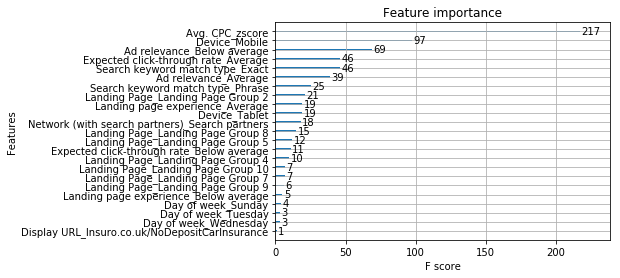

In [113]:
from xgboost import plot_importance

plt.figure(figsize=(20,10))
plot_importance(xgb)
plt.show()

### Test on past data

In [ ]:
# test on data

# first, select only one keyword for measurement

# second, clean dataset

# second, get z-score valuee of CPC from 0.01 to 1


In [218]:
testing='test_dataset.csv'
test=pd.read_csv(testing,sep=',',skiprows=2)
test1=test[test['Search keyword']=='cheap insurance']

In [223]:
#get number of words column
test1['No. of words']=test1['Search keyword'].apply(func.get_number_of_words)

#round up conversions values
test1['Conversions']=test1['Conversions'].apply(func.round_conv)

## drop ad columns that are useless
# ad_cols_to_drop=['Headline','Short headline', 'Long headline', 'Responsive Search Ad headline 1','Responsive Search Ad headline 2', 'Responsive Search Ad headline 3','Responsive Search Ad headline 4', 'Responsive Search Ad headline 5','Responsive Search Ad headline 6', 'Responsive Search Ad headline 7', 'Responsive Search Ad headline 8', 'Responsive Search Ad headline 9', 'Responsive Search Ad headline 10', 'Responsive Search Ad headline 11', 'Responsive Search Ad headline 12', 'Responsive Search Ad headline 13','Responsive Search Ad headline 14', 'Responsive Search Ad headline 15','Responsive Search Ad description 1', 'Responsive Search Ad description 2','Responsive Search Ad description 3','Responsive Search Ad description 4', 'Expanded text ad description 2', 'Description line 1','Description line 2','Ad']
ad_cols_to_drop=['Headline','Short headline','Long headline','Description','Headline 1','Headline 2', 'Responsive Search Ad headline 1','Responsive Search Ad headline 2', 'Responsive Search Ad headline 3','Responsive Search Ad headline 4', 'Responsive Search Ad headline 5','Responsive Search Ad headline 6', 'Responsive Search Ad headline 7', 'Responsive Search Ad headline 8', 'Responsive Search Ad headline 9', 'Responsive Search Ad headline 10', 'Responsive Search Ad headline 11', 'Responsive Search Ad headline 12', 'Responsive Search Ad headline 13','Responsive Search Ad headline 14', 'Responsive Search Ad headline 15','Responsive Search Ad description 1', 'Responsive Search Ad description 2','Responsive Search Ad description 3','Responsive Search Ad description 4', 'Expanded text ad description 2', 'Description line 1','Description line 2','Ad','Expanded text ad headline 3']

test1=test1.drop(test1[ad_cols_to_drop],axis=1)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [224]:
def fill_nan():
#     columns_fillna=['Headline','Description line 1','Description line 2','Display URL','Ad']
    columns_fillna=['Display URL']
    for i in columns_fillna:
        test1[i]=test1[i].fillna('Insuro.co.uk')
fill_nan()

In [226]:
# combine headline variables:

landing_page=['Path 1','Path 2']
test1['landing_page']=''
for i in landing_page:
    test1['landing_page']+=test1[i]

In [229]:
drop_col_list=['Day','Path 1','Path 2','Business name','Currency','CTR','Avg. CPC','Cost','Avg. position', 'Cost / conv.', 'Conv. rate']
test1.drop(drop_col_list,axis=1,inplace=True)

In [230]:
# convert all text groups and landing page to Ad Group # and Landing Page #
# 37 landing page groups
# 226 text ad groups
# text_ad_group=[]
landing_page_group=[]

for i in list(range(1,df['landing_page'].nunique()+1)):
    i='Landing Page Group '+str(i)
    landing_page_group.append(i)    
    
text_ad_group=pd.concat([pd.DataFrame(df['text_ads'].value_counts().sort_values(ascending=False)).reset_index(),pd.DataFrame(text_ad_group)], axis=1).drop(['text_ads'],axis=1).set_index('index').reset_index()
text_ad_group.columns=['ad group','Text Ad Group']
landing_page_group=pd.concat([pd.DataFrame(df['landing_page'].value_counts().sort_values(ascending=False)).reset_index(),pd.DataFrame(landing_page_group)], axis=1).drop(['landing_page'],axis=1).set_index('index').reset_index()
landing_page_group.columns=['landing page','Landing Page']

df=pd.merge(df,text_ad_group,left_on='text_ads',right_on='ad group').drop(['text_ads','ad group'],axis=1)
df=pd.merge(df,landing_page_group,left_on='landing_page',right_on='landing page').drop(['landing_page','landing page'],axis=1)

KeyError: 'landing_page'

In [172]:
test_f=pd.merge(test1,landing_page_group,left_on='landing_page',right_on='landing page').drop(['landing_page','landing page'],axis=1)
get_dummies_list=['Search keyword match type','Day of week','Device','Network (with search partners)','Landing page experience','Expected click-through rate','Ad relevance','Landing Page','Display URL']
test_f=pd.get_dummies(test_f, columns=get_dummies_list)

In [154]:
cpcs=test[test['Avg. CPC']>0]['Avg. CPC'].unique()

In [174]:
# add landing page experience columns
# ad relevance columns
# Expected click-through rate
# Display URL
# Landing page column
to_append=['Landing page experience_Below average','Landing page experience_Average',
'Expected click-through rate_Average','Expected click-through rate_Below average',
'Ad relevance_Average','Ad relevance_Below average',
'Landing Page_Landing Page Group 10','Landing Page_Landing Page Group 11','Landing Page_Landing Page Group 12','Landing Page_Landing Page Group 13','Landing Page_Landing Page Group 14',
'Landing Page_Landing Page Group 15','Landing Page_Landing Page Group 16','Landing Page_Landing Page Group 17','Landing Page_Landing Page Group 18','Landing Page_Landing Page Group 19',
'Landing Page_Landing Page Group 2','Landing Page_Landing Page Group 20','Landing Page_Landing Page Group 21','Landing Page_Landing Page Group 22','Landing Page_Landing Page Group 23',
'Landing Page_Landing Page Group 24','Landing Page_Landing Page Group 25','Landing Page_Landing Page Group 26','Landing Page_Landing Page Group 27','Landing Page_Landing Page Group 28',
'Landing Page_Landing Page Group 29','Landing Page_Landing Page Group 3','Landing Page_Landing Page Group 30','Landing Page_Landing Page Group 4','Landing Page_Landing Page Group 5',
'Landing Page_Landing Page Group 6','Landing Page_Landing Page Group 7','Landing Page_Landing Page Group 8','Landing Page_Landing Page Group 9',
'Display URL_Insuro.co.uk/Black-Box-Insurance','Display URL_Insuro.co.uk/Cheap-Car-Insurance','Display URL_Insuro.co.uk/Compare-Car-Insurance','Display URL_Insuro.co.uk/Get-Car-Insurance','Display URL_Insuro.co.uk/No-Deposit-Insurance',
'Display URL_Insuro.co.uk/NoDepositCarInsurance']

In [175]:
test_f.columns
test_f.shape
missing=[]
for i in test_f.columns:
    if i not in X.columns:
        missing.append(i)
test_f=test_f.drop(missing,axis=1)

In [186]:
#Create Standardized Column
avgcpc_stddev=pd.DataFrame(df[df['Conversions']>0].groupby('Search keyword').agg(np.std, ddof=0)['Avg. CPC']).rename(index=str, columns={"Avg. CPC": "Avg. CPC_StdDev"})

In [188]:
cheapins=df[df['Search keyword']=='cheap insurance']
cpc_test=pd.DataFrame(np.arange(0.00,1.45,0.01),columns=['Avg. CPC'])
cpc_test['mean']=np.mean(cheapins['Avg. CPC'])
cpc_test['std']=np.std(cheapins['Avg. CPC'])
cpc_test['Avg. CPC_zscore']=(cpc_test['Avg. CPC']-cpc_test['mean'])/cpc_test['std']

In [221]:
test_f['id']=np.arange(1,128,1)
test_ff=pd.DataFrame(np.repeat(test_f.values,145,axis=0))
test_ff.columns = test_f.columns

In [239]:
pricez=pd.concat([cpc_test]*127, ignore_index=True)['Avg. CPC_zscore']

In [241]:
test_ff['Avg. CPC_zscore']=pricez
final_test_df=test_ff.drop(['id'],axis=1)
final_test_df

In [283]:
final_test_df=final_test_df[X_train_regr.columns]
test_ff['pred_bin']=clf_conv_sgd_2pm.predict(final_test_df)
test_ff['pred_conv']=xgb_2pm.predict(final_test_df)**3
test_ff['predictions']=test_ff['pred_bin']*test_ff['pred_conv']

In [330]:
test_ff[test_ff['id']==5].sort_values(by='predictions',ascending=False)
test_ff.groupby('id').max()['Avg. CPC_zscore'].value_counts()

,No. of words,Search keyword match type_Exact,Search keyword match type_Phrase,Day of week_Monday,Day of week_Saturday,Day of week_Sunday,Day of week_Thursday,Day of week_Tuesday,Day of week_Wednesday,Device_Mobile,...,Display URL_Insuro.co.uk/Cheap-Car-Insurance,Display URL_Insuro.co.uk/Compare-Car-Insurance,Display URL_Insuro.co.uk/Get-Car-Insurance,Display URL_Insuro.co.uk/No-Deposit-Insurance,Display URL_Insuro.co.uk/NoDepositCarInsurance,id,Avg. CPC_zscore,pred_bin,pred_conv,predictions
668,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,1.460818,1,5.628484,5.628484
635,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,-0.644795,1,4.331770,4.331770
649,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,0.248495,1,4.286405,4.286405
642,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,-0.198150,1,4.286405,4.286405
648,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,0.184689,1,4.286405,4.286405
647,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,0.120882,1,4.286405,4.286405
646,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,0.057076,1,4.286405,4.286405
645,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,-0.006731,1,4.286405,4.286405
644,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,-0.070537,1,4.286405,4.286405
643,2,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,5,-0.134344,1,4.286405,4.286405


In [337]:
#sun of total predictions
sum(test_ff.groupby('id').max()['predictions'])

370.8567065000534

In [331]:
1.450818*np.std(cheapins['Avg. CPC'])+np.mean(cheapins['Avg. CPC'])

0.8784327777629666

In [ ]:
# clf_conv_sgd_2pm.predict(X_val)
# xgb_2pm.predict(X_val)
val_results=pd.DataFrame({'true values':y_val,'classifier':clf_conv_sgd_2pm.predict(X_val),'conversions':(xgb_2pm.predict(X_val)**3)})
val_results['predictions']=val_results['classifier']*val_results['conversions']
val_results['rmse']=((val_results['true values']-val_results['predictions'])**2)
(val_results['rmse'].mean()**0.5)